In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import keras

import warnings
warnings.filterwarnings("ignore")

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    #i: n_in, n_in-1, ..., 1，为滞后期数
    #分别代表t-n_in, ... ,t-1期
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #i: 0, 1, ..., n_out-1，为超前预测的期数
    #分别代表t，t+1， ... ,t+n_out-1期
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
def prepare_data(filepath, n_in, n_out=30, n_vars=4, train_proportion=0.8):
    #读取数据集
    dataset = pd.read_csv(filepath)
    #设置时间戳索引
    dataset['date'] = pd.to_datetime(dataset['date'])
    dataset.set_index("date", inplace=True)
    values = dataset.values
    #保证所有数据都是float32类型
    values = values.astype('float32')
    #变量归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    #将时间序列问题转化为监督学习问题
    reframed = series_to_supervised(scaled, n_in, n_out)
    #取出保留的变量
    contain_vars = []
    for i in range(1, n_in+1):
        contain_vars += [('var%d(t-%d)' % (j, i)) for j in range(1,n_vars+1)]  
    data = reframed [ contain_vars + ['var1(t)'] + [('var1(t+%d)' % (j)) for j in range(1,n_out)]]
    #修改列名
    col_names = ['Y', 'X1', 'X2', 'X3']
    contain_vars = []
    for i in range(n_vars):
        contain_vars += [('%s(t-%d)' % (col_names[i], j)) for j in range(1,n_in+1)]  
    data.columns = contain_vars +  ['Y(t)'] + [('Y(t+%d)' % (j)) for j in range(1,n_out)]
    #分隔数据集，分为训练集和测试集
    values = data.values
    n_train = round(data.shape[0]*train_proportion)
    train = values[:n_train, :]
    test = values[n_train:, :]
    #分隔输入X和输出y
    train_X, train_y = train[:, :n_in*n_vars], train[:, n_in*n_vars:]
    test_X, test_y = test[:, :n_in*n_vars], test[:, n_in*n_vars:]
    #将输入X改造为LSTM的输入格式，即[samples,timesteps,features]
    train_X = train_X.reshape((train_X.shape[0], n_in, n_vars))
    test_X = test_X.reshape((test_X.shape[0], n_in, n_vars))
    return scaler, data, train_X, train_y, test_X, test_y, dataset

In [46]:
def fit_lstm(data_prepare, n_neurons=50, n_batch=72, n_epoch=100, loss='mae', optimizer='adam', repeats=1):
    train_X = data_prepare[2]
    train_y = data_prepare[3]
    test_X = data_prepare[4]
    test_y = data_prepare[5]
    model_list = []
    for i in range(repeats):
        #设计神经网络
        model = keras.models.Sequential()
        # 一层LSTM，n_neurons是中间隐空间维度
        model.add(keras.layers.LSTM(n_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(keras.layers.Dense(train_y.shape[1]))
        model.compile(loss=loss, optimizer=optimizer)
        #拟合神经网络
        history = model.fit(train_X, train_y, epochs=n_epoch, batch_size=n_batch, validation_data=(test_X, test_y), verbose=0, shuffle=False)
        #画出学习过程
        p1 = plt.plot(history.history['loss'], color='blue', label='train')
        p2 = plt.plot(history.history['val_loss'], color='yellow',label='test')
        #保存model
        model_list.append(model)
    plt.legend(["train","test"])
    plt.show()
    return model_list

In [7]:
def lstm_predict(model, data_prepare):
    scaler = data_prepare[0]
    test_X = data_prepare[4]
    test_y = data_prepare[5]
    #做出预测
    yhat = model.predict(test_X)
    #将测试集上的预测值还原为原来的数据维度
    scale_new = MinMaxScaler()
    scale_new.min_, scale_new.scale_ = scaler.min_[0], scaler.scale_[0]
    inv_yhat = scale_new.inverse_transform(yhat)
    #将测试集上的实际值还原为原来的数据维度
    inv_y = scale_new.inverse_transform(test_y)
    return inv_yhat, inv_y

In [8]:
# 计算每一步预测的RMSE
def evaluate_forecasts(test, forecasts, n_out):
    rmse_dic = {}
    for i in range(n_out):
        actual = [float(row[i]) for row in test]
        predicted = [float(forecast[i]) for forecast in forecasts]
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        rmse_dic['t+' + str(i+1) + ' RMSE'] = rmse
    return rmse_dic

In [9]:
#以原始数据为背景画出预测数据
def plot_forecasts(series, forecasts):
    #用蓝色画出原始数据集
    plt.plot(series.values)
    n_seq = len(forecasts[0])
    #用红色画出预测值
    for i in range(1,len(forecasts)+1):
        xaxis = [x for x in range(i, i+n_seq+1)]
        yaxis = [float(series.iloc[i-1,0])] + list(forecasts[i-1])
        plt.plot(xaxis, yaxis, color='red')
    #展示图像
    plt.show()

In [50]:
inv_yhat.shape

(196, 30)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




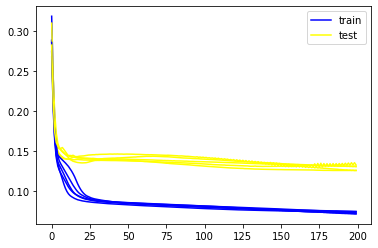

In [11]:
#定义需要的变量
filepath = './data/data.csv'  # r'C:\Users\87689\Desktop\国贸实习\Premium\导出文件.csv'
n_in = 15  # 输入 seq len
n_out = 30  # 输出 seq len
n_vars = 4  # 输入 dimension
n_neuron = 5  # 隐空间维度
n_batch = 16
n_epoch = 200
repeats = 5
inv_yhat_list = []
inv_y_list = []

data_prepare = prepare_data(filepath,n_in, n_out)
# scaler, data, train_X, train_y, test_X, test_y, dataset = data_prepare
model_list = fit_lstm(data_prepare, n_neuron, n_batch, n_epoch,repeats=repeats)
for i in range(len(model_list)):
    model = model_list[i]
    inv_yhat, inv_y = lstm_predict(model, data_prepare)
    
    inv_yhat_list.append(inv_yhat)
    inv_y_list.append(inv_y)

In [36]:
train_X.shape

(784, 15, 4)

In [51]:
train_y.shape

(784, 30)

In [37]:
_, _, _, _, test_X, test_y, dataset = data_prepare

In [12]:
inv_yhat_ave = np.zeros(inv_y.shape)
for i in range(repeats):
    inv_yhat_ave += inv_yhat_list[i]
    
inv_yhat_ave = inv_yhat_ave/repeats

In [13]:
rmse_dic_list = []
for i in range(len(model_list)):
    inv_yhat = inv_yhat_list[i]
    inv_y = inv_y_list[i]
    rmse_dic = evaluate_forecasts(inv_y, inv_yhat, n_out)
    rmse_dic_list.append(rmse_dic)

rmse_dic_list.append(evaluate_forecasts(inv_y, inv_yhat_ave, n_out))

df_dic = {}
for i in range(len(rmse_dic_list) - 1):
    df_dic['第' + str(i+1) + '次'] = pd.Series(rmse_dic_list[i])
    
df_dic['平均'] = pd.Series(rmse_dic_list[i+1])
rmse_df = pd.DataFrame(df_dic)
rmse_df

,第1次,第2次,第3次,第4次,第5次,平均
t+1 RMSE,5.601802,5.451843,4.859366,5.807525,6.369720,5.416907
t+2 RMSE,5.882780,6.427986,5.513729,6.634724,6.646348,5.934257
t+3 RMSE,6.591895,6.847620,5.985383,7.133683,6.906003,6.505609
t+4 RMSE,6.985452,6.938359,7.096449,7.675106,8.036417,7.147528
t+5 RMSE,7.515896,7.474042,7.392986,8.185160,8.191390,7.560844
t+6 RMSE,8.125511,8.683548,8.125623,8.749951,8.645348,8.303698
t+7 RMSE,8.971976,9.354416,8.530376,9.386347,9.458555,9.007260
t+8 RMSE,9.370268,10.234100,9.291782,9.757634,10.099125,9.579230
t+9 RMSE,9.906633,10.280385,9.814799,10.601998,10.426902,10.099391
t+10 RMSE,10.626069,10.928726,10.456970,11.209543,10.844380,10.696310


In [14]:
s = inv_yhat_ave[0].shape
erro_rate = np.zeros(s)
for i in range(len(inv_y)):
    erro_rate += inv_yhat_ave[i]/inv_y[i]-1

erro_rate_ave = erro_rate/len(inv_y)
err_df = pd.DataFrame(pd.Series(erro_rate_ave))
err_df.columns = ['平均预测错误率']
err_df.index = ['超前%d步预测' % (i+1) for i in range(n_out)]
err_df

,平均预测错误率
超前1步预测,0.049385
超前2步预测,0.050914
超前3步预测,0.054411
超前4步预测,0.057776
超前5步预测,0.055563
超前6步预测,0.059660
超前7步预测,0.065500
超前8步预测,0.065916
超前9步预测,0.069849
超前10步预测,0.070341


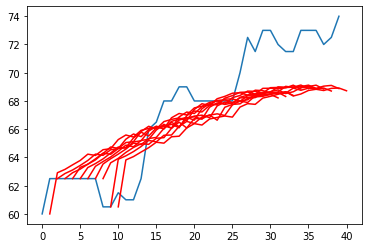

In [23]:
dataset = data_prepare[6]
test_X = data_prepare[4]
n_real = len(dataset)-len(test_X)-len(inv_yhat_ave[0])
#多画一个
y_real = pd.DataFrame(dataset['avg'][n_real:n_real+10+30])
plot_forecasts(y_real, inv_yhat_ave[0:10])

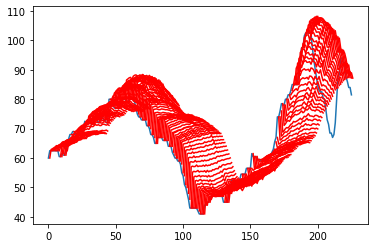

In [24]:
n_real = len(dataset)-len(test_X)-len(inv_yhat[0])
#多画一个
y_real = pd.DataFrame(dataset['avg'][n_real:])
plot_forecasts(y_real, inv_yhat_ave)